# **Сборный Проект — 2. HR-аналитика**

**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

**Задачи**
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Входные данные для Задач 1 и 2**
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.


**Файлы с данными Задача 1**
- Тренировочная выборка: train_job_satisfaction_rate.csv
- Входные признаки тестовой выборки: test_features.csv
- Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv

**Файлы с данными Задача 2**
- Тренировочная выборка: train_quit.csv
- Входные признаки тестовой выборки те же, что и в прошлой задаче: test_features.csv
- Целевой признак тестовой выборки: test_target_quit.csv

**План работы к Задачам 1 и 2**
- Шаг 1. Загрузка данных
- Шаг 2. Предобработка данных
- Шаг 3. Исследовательский анализ данных
- Шаг 4. Добавление нового входного признака
- Шаг 5. Подготовка данных
- Шаг 6. Обучение модели
- Шаг 7. Выводы
- Общий вывод

# Импорт библиотек

In [1]:
!pip install shap -q
!pip -q install phik
!pip install scikit-learn -U

     |████████████████████████████████| 13.4 MB 2.1 MB/s eta 0:00:010:00:03
     |████████████████████████████████| 301 kB 75.7 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder

from phik.report import plot_correlation_matrix
import shap
import phik

# Шаг 1. Задача 1.  Загрузка данных

In [3]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test = pd.read_csv('/datasets/test_features.csv')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
display (train.head())
print (train.info())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


In [5]:
display (X_test.head())
print (X_test.info())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


In [6]:
display (y_test.head())
print (y_test.info())

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


**Вывод по Шагу 1. Задача 1**
- данные импортированы 
- данных для исследования достаточно 
- на первый взгляд есть пропуски 

Данные подготовлены для дальнейшей работы

# Шаг 2. Задача 1. Предобработка данных

Сделаем id индексом в датафреймах

In [7]:
train.set_index('id', inplace=True)
X_test.set_index('id', inplace=True)
y_test.set_index('id', inplace=True)

Проверим наличие явных дублей

In [8]:
print (train.duplicated().sum())
print (X_test.duplicated().sum())

245
557


Трудно представить, что столько параметров совпадает у разных сотрудников. Предлагаю удалить их, т.к. может в дальнейшем привести к переобучению модели. На тестовую выборку это не повлияет, ее рогать не будем. 

In [9]:
train = train.drop_duplicates()
print (train.duplicated().sum())

0


Теперь проверим на неявные дубли и исправим при необходимости

In [10]:
print (train['dept'].unique())
print (X_test['dept'].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']


In [11]:
X_test.loc[X_test['dept'] == ' ', 'dept'] = np.nan
print (X_test['dept'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]


In [12]:
print (train['level'].unique())
print (X_test['level'].unique())

['junior' 'middle' 'sinior' nan]
['junior' 'middle' 'sinior' nan]


In [13]:
print (train['workload'].unique())
print (X_test['workload'].unique())

['medium' 'high' 'low']
['medium' 'low' 'high' ' ']


In [14]:
X_test.loc[X_test['workload'] == ' ', 'workload'] = np.nan
print (X_test['workload'].unique())

['medium' 'low' 'high' nan]


In [15]:
print (train['employment_years'].unique())
print (X_test['employment_years'].unique())

[ 2  1  4  7  9  6  3 10  8  5]
[ 2  1  5  6  3  9  7  4  8 10]


In [16]:
print (train['last_year_promo'].unique())
print (X_test['last_year_promo'].unique())

['no' 'yes']
['no' 'yes']


In [17]:
print (train['last_year_violations'].unique())
print (X_test['last_year_violations'].unique())

['no' 'yes']
['no' 'yes']


In [18]:
print (train['supervisor_evaluation'].unique())
print (X_test['supervisor_evaluation'].unique())

[1 5 2 3 4]
[5 4 3 1 2]


Посмотрим на количество пропусков 

In [19]:
print (train.isnull().sum())
print ('-------------------------------')
print (X_test.isnull().sum())

dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
-------------------------------
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


**Вывод по Шагу 2. Задача 1**
- id во фреймах перевели в индекс
- удалены явные дубли в тренировочной выборке. В тестовой выборке не удаляли, т.к. не повлияет на обучение модели. 
- удалены неявные дубли, пропущенным значением присвоили "nan", согласно заданию, они будут обработаны в пайплайне
- тип данных в порядке 

Данные подготовлены для дальнейшей работы

# Шаг 3. Задача 1. Исследовательский анализ данных

**Посмотрим на категориальные признаки**

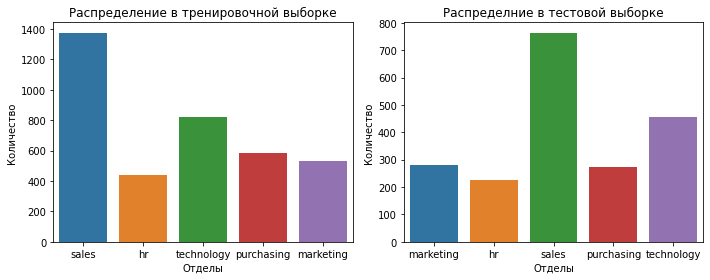

In [20]:
# Создание гистограмм по столбцу "dept"
x1 = train['dept']
x2 = X_test['dept']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Отделы')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Отделы')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

In [21]:
#Некорректно написан senior,  поменяем 
train.loc[train['level'] == 'sinior', 'level'] = 'senior'
X_test.loc[X_test['level'] == 'sinior', 'level'] = 'senior'

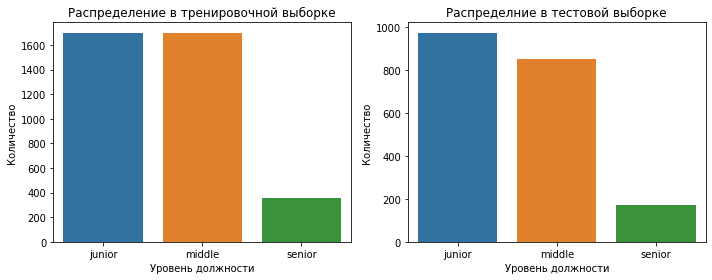

In [22]:
# Создание гистограмм по столбцу "level"
x1 = train['level']
x2 = X_test['level']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Уровень должности')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Уровень должности')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

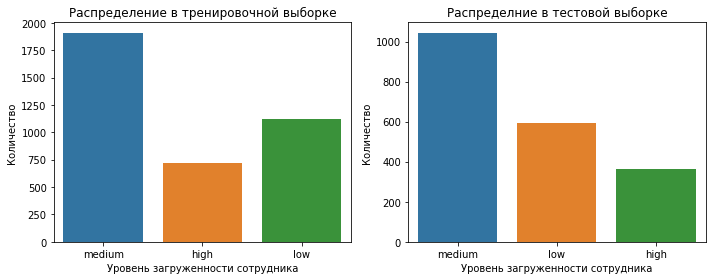

In [23]:
# Создание гистограмм по столбцу "workload"
x1 = train['workload']
x2 = X_test['workload']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Уровень загруженности сотрудника')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Уровень загруженности сотрудника')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

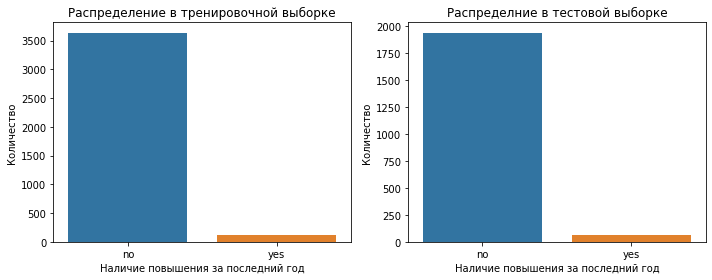

In [24]:
# Создание гистограмм по столбцу "last_year_promo"
x1 = train['last_year_promo']
x2 = X_test['last_year_promo']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Наличие повышения за последний год')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Наличие повышения за последний год')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

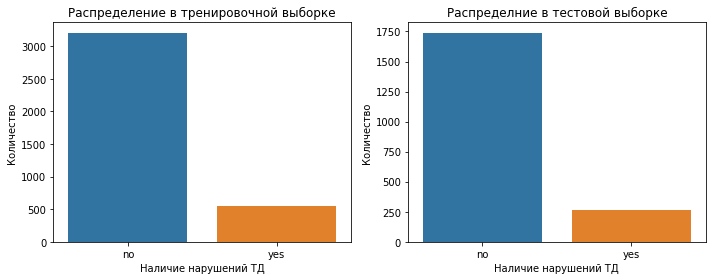

In [25]:
# Создание гистограмм по столбцу "last_year_violations"
x1 = train['last_year_violations']
x2 = X_test['last_year_violations']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Наличие нарушений ТД')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Наличие нарушений ТД')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

**Посмотрим на количественные признаки**

In [26]:
train.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000,3755.000000
mean,3.817044,3.463648,34457.416778,0.532554
std,2.557142,1.026265,15050.643870,0.226393
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,31200.000000,0.550000
75%,6.000000,4.000000,44400.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [27]:
X_test.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


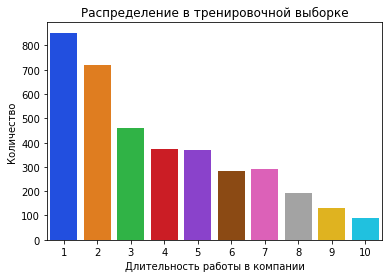

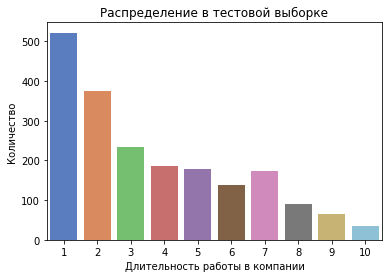

In [28]:
sns.countplot(x='employment_years', data=train, palette='bright')
plt.title('Распределение в тренировочной выборке')
plt.xlabel('Длительность работы в компании')
plt.ylabel('Количество')
plt.show()

sns.countplot(x='employment_years', data=X_test, palette='muted')
plt.title('Распределение в тестовой выборке')
plt.xlabel('Длительность работы в компании')
plt.ylabel('Количество')
plt.show()

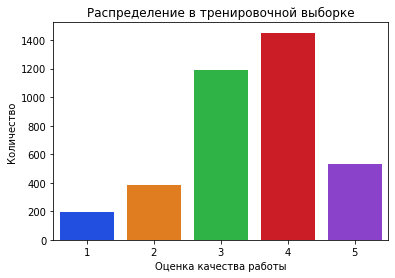

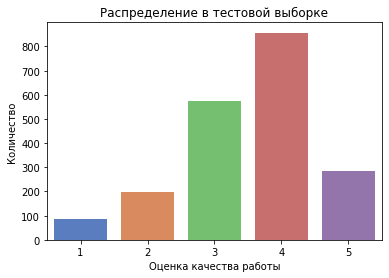

In [29]:
sns.countplot(x='supervisor_evaluation', data=train, palette='bright')
plt.title('Распределение в тренировочной выборке')
plt.xlabel('Оценка качества работы')
plt.ylabel('Количество')
plt.show()

sns.countplot(x='supervisor_evaluation', data=X_test, palette='muted')
plt.title('Распределение в тестовой выборке')
plt.xlabel('Оценка качества работы')
plt.ylabel('Количество')
plt.show()

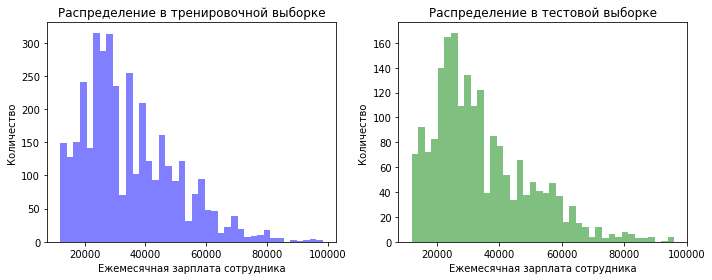

In [30]:
# Создание данных для гистограмм 'salary'
x1 = train['salary']
x2 = X_test['salary']

# Создание гистограмм
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(x1, bins=40, color='blue', alpha=0.5)
ax[0].set_title('Распределение в тренировочной выборке')
ax[0].set_xlabel('Ежемесячная зарплата сотрудника')
ax[0].set_ylabel('Количество')
ax[1].hist(x2, bins=40, color='green', alpha=0.5)
ax[1].set_title('Распределение в тестовой выборке')
ax[1].set_xlabel('Ежемесячная зарплата сотрудника')
ax[1].set_ylabel('Количество')

#Настройка внешнего вида графика
plt.tight_layout()
plt.show()

В целом наблюдается равномерное распредение с небольшим уклоном вправо 

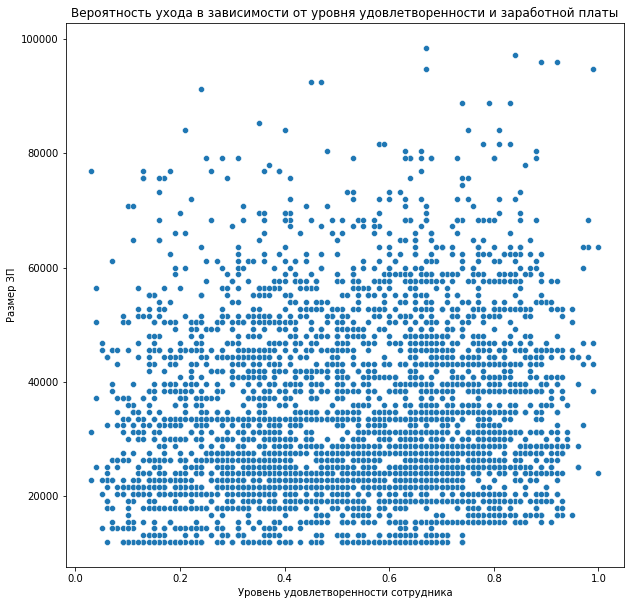

In [31]:
fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=train, x="job_satisfaction_rate", y="salary")
plt.xlabel('Уровень удовлетворенности сотрудника')
plt.ylabel('Размер ЗП')
plt.title('Вероятность ухода в зависимости от уровня удовлетворенности и заработной платы')
plt.show()

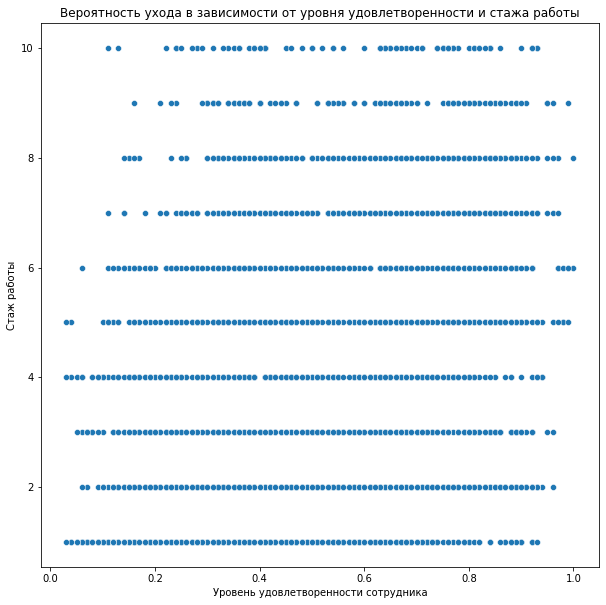

In [32]:
fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=train, x="job_satisfaction_rate", y="employment_years")
plt.xlabel('Уровень удовлетворенности сотрудника')
plt.ylabel('Стаж работы')
plt.title('Вероятность ухода в зависимости от уровня удовлетворенности и стажа работы')
plt.show()

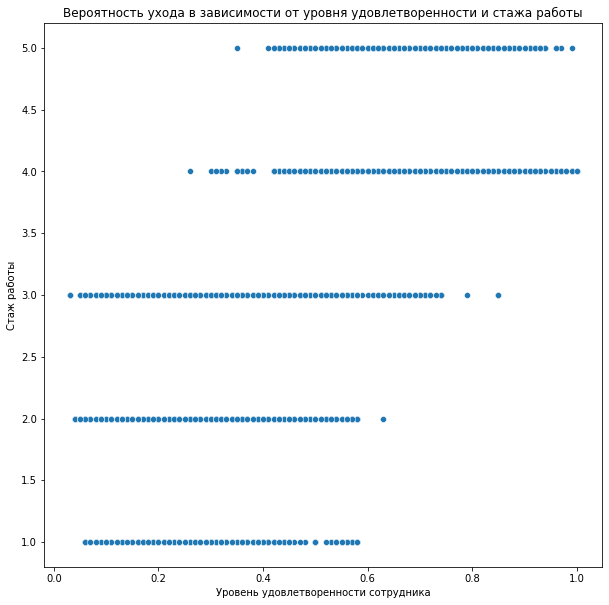

In [33]:
fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=train, x="job_satisfaction_rate", y="supervisor_evaluation")
plt.xlabel('Уровень удовлетворенности сотрудника')
plt.ylabel('Стаж работы')
plt.title('Вероятность ухода в зависимости от уровня удовлетворенности и стажа работы')
plt.show()

Text(0, 0.5, 'Уровень удовлетворенности')

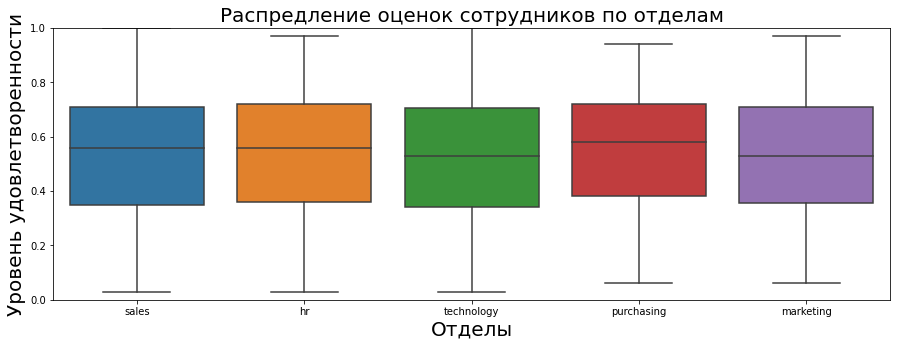

In [34]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=train, x='dept', y='job_satisfaction_rate')
ax.set(ylim=(0,1))
plt.title('Распредление оценок сотрудников по отделам', fontsize=20)
plt.xlabel('Отделы', fontsize=20)
plt.ylabel('Уровень удовлетворенности',fontsize=20)

**Выводы по исследовательскому анализу**

Рассмотрев категориальные и количественные признаки в двух выборках можно сказать следующее:
- Данные в тренировочной и тестовой выборках распределены пропорционально, так что особо они не отличаются 
- выбросов и аномалий не наблюдается

Text(0, 0.5, 'Уровень удовлетворенности')

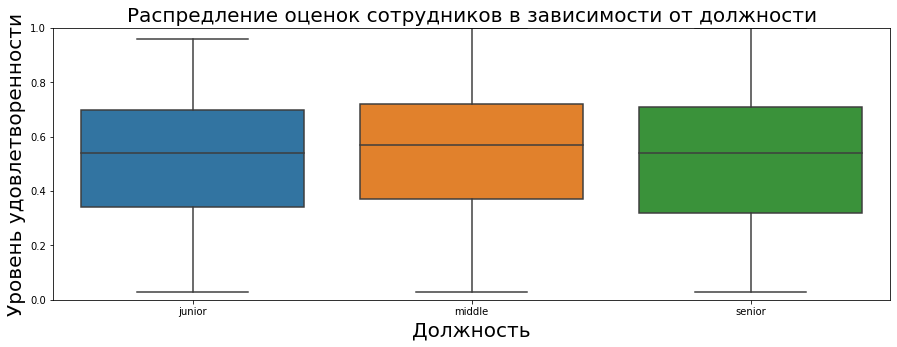

In [35]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=train, x='level', y='job_satisfaction_rate')
ax.set(ylim=(0,1))
plt.title('Распредление оценок сотрудников в зависимости от должности', fontsize=20)
plt.xlabel('Должность', fontsize=20)
plt.ylabel('Уровень удовлетворенности',fontsize=20)

Text(0, 0.5, 'Уровень удовлетворенности')

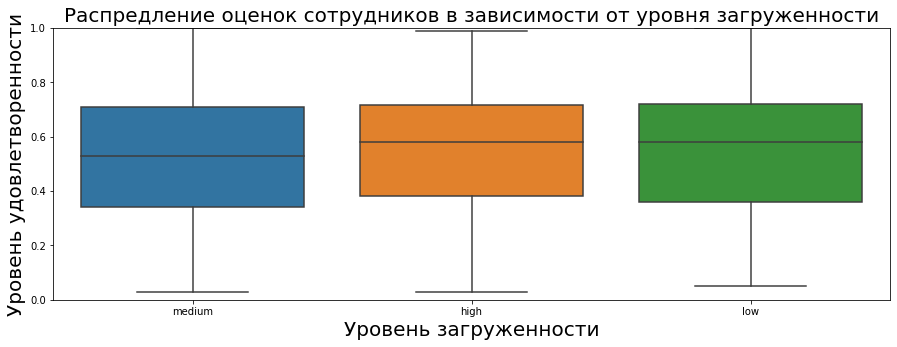

In [36]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=train, x='workload', y='job_satisfaction_rate')
ax.set(ylim=(0,1))
plt.title('Распредление оценок сотрудников в зависимости от уровня загруженности', fontsize=20)
plt.xlabel('Уровень загруженности', fontsize=20)
plt.ylabel('Уровень удовлетворенности',fontsize=20)

Text(0, 0.5, 'Уровень удовлетворенности')

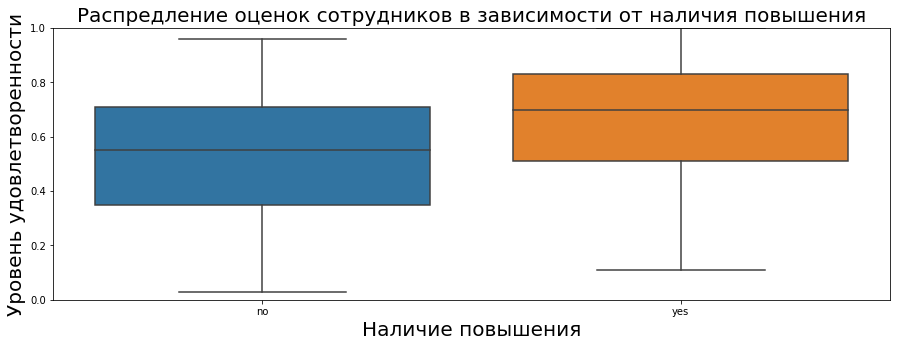

In [37]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=train, x='last_year_promo', y='job_satisfaction_rate')
ax.set(ylim=(0,1))
plt.title('Распредление оценок сотрудников в зависимости от наличия повышения', fontsize=20)
plt.xlabel('Наличие повышения', fontsize=20)
plt.ylabel('Уровень удовлетворенности',fontsize=20)

Text(0, 0.5, 'Уровень удовлетворенности')

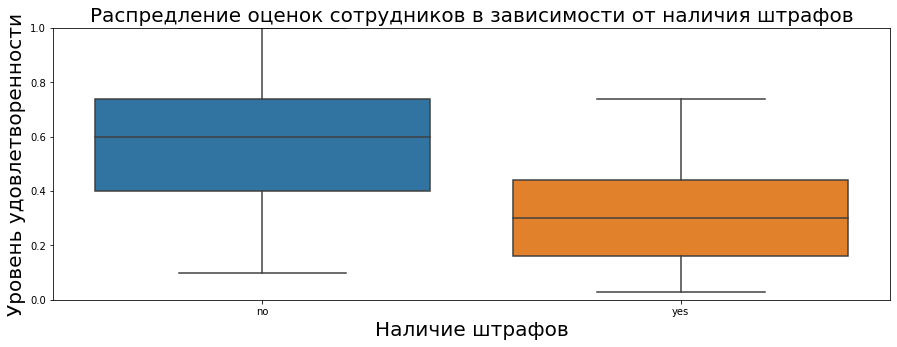

In [38]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=train, x='last_year_violations', y='job_satisfaction_rate')
ax.set(ylim=(0,1))
plt.title('Распредление оценок сотрудников в зависимости от наличия штрафов', fontsize=20)
plt.xlabel('Наличие штрафов', fontsize=20)
plt.ylabel('Уровень удовлетворенности',fontsize=20)

**Распределение job_satisfaction_rate**

Можно заметить, что сильно влияет на уровень удолвлетворенности сотрудников: 

- наличие штрафов 
- наличие повышения за прошлый год 
- в целом показатели у джунов (отработавших менее 4-х лет сотрудников) показатели ниже

По остальным признакам можно увидеть равномерное распредление оценок

**Посмотрим как признаки коррелируют**

In [39]:
train.phik_matrix(interval_cols = ['salary', 'job_satisfaction_rate']).style.background_gradient(cmap ='coolwarm')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.018079,0.025931,0.000000,0.000000,0.100579,0.270239,0.074739
level,0.000000,1.000000,0.404459,0.675467,0.100352,0.000000,0.000000,0.714411,0.077260
workload,0.018079,0.404459,1.000000,0.165879,0.057938,0.000000,0.037565,0.785277,0.043958
employment_years,0.025931,0.675467,0.165879,1.000000,0.180832,0.043766,0.000000,0.469992,0.319331
last_year_promo,0.000000,0.100352,0.057938,0.180832,1.000000,0.011274,0.016247,0.211173,0.191464
last_year_violations,0.000000,0.000000,0.000000,0.043766,0.011274,1.000000,0.183221,0.000000,0.566993
supervisor_evaluation,0.100579,0.000000,0.037565,0.000000,0.016247,0.183221,1.000000,0.000000,0.762964
salary,0.270239,0.714411,0.785277,0.469992,0.211173,0.000000,0.000000,1.000000,0.149599
job_satisfaction_rate,0.074739,0.077260,0.043958,0.319331,0.191464,0.566993,0.762964,0.149599,1.000000


In [40]:
X_test.phik_matrix(interval_cols = ['salary']).style.background_gradient(cmap ='coolwarm')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
dept,1.000000,0.000000,0.033894,0.000000,0.000000,0.000000,0.060917,0.330406
level,0.000000,1.000000,0.474151,0.689666,0.118258,0.017527,0.000000,0.748998
workload,0.033894,0.474151,1.000000,0.202240,0.035609,0.000000,0.036353,0.785849
employment_years,0.000000,0.689666,0.202240,1.000000,0.173637,0.066371,0.000000,0.494701
last_year_promo,0.000000,0.118258,0.035609,0.173637,1.000000,0.000000,0.011704,0.193727
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000
supervisor_evaluation,0.060917,0.000000,0.036353,0.000000,0.011704,0.189719,1.000000,0.114588
salary,0.330406,0.748998,0.785849,0.494701,0.193727,0.000000,0.114588,1.000000


**Выводы относительно корреляции:**
- Корреляция признаков в тестовой и тренировочной выборках примерно одинаковая
- Т.к. связь между признаками менее 0.9 править/удалять ничего не надо
- Сильная связь в тренировочной выборке между целевым признаком job_satisfaction_rate и признаками supervisor_evaluation & last_year_violations
- Стоит отметить сильную связь в обеих выборках между признаками salary, level, workload  и в меньшей степени их связь с employment_year и dept

# Шаг 4. Задача 1. Подготовка данных

Сделаем константы

In [41]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

Подготовим данные 

In [42]:
X_train = train.drop(['job_satisfaction_rate'], axis = 1)
y_train = train['job_satisfaction_rate']

X_train.shape, X_test.shape

((3755, 8), (2000, 8))

Создаём списки с названиями признаков

In [43]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary']

Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование SimpleImputer + OHE

In [44]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output =False)
        )
    ]
) 

Создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование SimpleImputer + OE

In [45]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=-1
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Создаём общий пайплайн для подготовки данных

In [46]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Создаём итоговый пайплайн: подготовка данных и модель

In [47]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Перебираем гиперпараметры моделей

In [48]:
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [Ridge(random_state = RANDOM_STATE)],
        'models__solver': ['saga', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

Добавим метрику SMAPE

In [49]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_true-y_pred)/((np.abs(y_true) + np.abs(y_pred))/2))

smape_scorer = make_scorer(smape, greater_is_better = False)

Автоматический подбор с помощью GridSearchCV

In [50]:
grid_search = GridSearchCV(
    pipe_final, 
    param_distributions, 
    cv = 5,
    scoring=smape_scorer, 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [Ridge(random_state=42)],
                          'models__solver': ['saga', 'auto'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

Вывод лучшей модели и метрик

In [51]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print (f'Метрика лучшей модели на тренировочной выборке: {-grid_search.best_score_}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Работа модели на тестовой выборке

In [52]:
y_test = y_test.sort_index()
X_test = X_test.sort_index()

y_predict = grid_search.predict(X_test)

smape(np.array(y_test['job_satisfaction_rate']), y_predict)

13.581003491925054

**Вывод по Шагу 5. Задача 1**

- создан пайплан
- лучшая всего на кросс-валидации показала себя модель DecisionTreeRegressor(min_samples_split=8, random_state=42)
- С помощью метрики SMAPE (Symmetric Mean Absolute Percentage Error) получили, что процентное отклонение между прогнозируемыми и фактическими значениями составляет 13,58, что говорит о том, что модель показала себя довольно хорошо


# Шаг 6. Задача 1. Оформление  промежуточных выводов

- На текущем этапе была выбрана и обучена наилучшая модель для прогнозирования уровня удовлетворенности сотрудников своей работой. 
- Метрика на тестовой выборке составила 14.89, что говорит о довольно холрошей работе модели
- Наилучшей моделью оказалась DecisionTreeRegressor(min_samples_split=8, random_state=42) 

# Шаг 1. Задача 2. Загрузка данных

In [53]:
train2 = pd.read_csv('/datasets/train_quit.csv')
X_test2 = pd.read_csv('/datasets/test_features.csv')
y_test2 = pd.read_csv('/datasets/test_target_quit.csv')

In [54]:
display(train2)
train2.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [55]:
display(X_test2)
X_test2.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [56]:
display(y_test2)
y_test2.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
...,...,...
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


**Вывод по Шагу 1. Задача 2**
- данные импортированы 
- данных для исследования достаточно 
- на первый взгляд есть пропуски 

Данные подготовлены для дальнейшей работы

# Шаг 2. Задача 2. Предобработка данных

In [57]:
#print (train2.duplicated().sum())

Объединим тестовые данные для удобства 

In [58]:
merged_test2 = X_test2.merge(y_test2, on='id', how='left')
display (merged_test2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,yes
1996,109582,technology,middle,low,3,no,no,2,21600,yes
1997,305653,technology,junior,low,1,no,no,3,14400,yes
1998,160233,technology,middle,low,8,no,no,1,32400,no


Сделаем id индексом в датафреймах

In [59]:
train2.set_index('id', inplace=True)
merged_test2.set_index('id', inplace=True)

Проверим наличие явных дублей и удалим в тренировочной выгрузке

In [60]:
print (train2.duplicated().sum())
train2 = train2.drop_duplicates()
print (train2.duplicated().sum())

1413
0


Проверим наличие неявных дублей 

In [61]:
print (train2['dept'].unique())
print (merged_test2['dept'].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']


In [62]:
merged_test2.loc[merged_test2['dept'] == ' ', 'dept'] = np.nan
print (merged_test2['dept'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]


In [63]:
print (train2['level'].unique())
print (merged_test2['level'].unique())

['middle' 'junior' 'sinior']
['junior' 'middle' 'sinior' nan]


In [64]:
train2.loc[train2['level'] == 'sinior', 'level'] = 'senior'
merged_test2.loc[merged_test2['level'] == 'sinior', 'level'] = 'senior'

In [65]:
print (train2['level'].unique())
print (merged_test2['level'].unique())

['middle' 'junior' 'senior']
['junior' 'middle' 'senior' nan]


In [66]:
print (train2['workload'].unique())
print (merged_test2['workload'].unique())

['high' 'medium' 'low']
['medium' 'low' 'high' ' ']


In [67]:
merged_test2.loc[merged_test2['workload'] == ' ', 'workload'] = np.nan
print (merged_test2['workload'].unique())

['medium' 'low' 'high' nan]


In [68]:
print (train2['last_year_promo'].unique())
print (merged_test2['last_year_promo'].unique())

['no' 'yes']
['no' 'yes']


In [69]:
print (train2['last_year_violations'].unique())
print (merged_test2['last_year_violations'].unique())

['no' 'yes']
['no' 'yes']


In [70]:
print (train2['quit'].unique())
print (merged_test2['quit'].unique())

['no' 'yes']
['no' 'yes']


Посмотрим на количество пропусков (Обработаем их в пайплайне)

In [71]:
print (train2.isnull().sum())
print ('-------------------------------')
print (merged_test2.isnull().sum())

dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
-------------------------------
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


**Вывод по Шагу 2. Задача 2**
- id во фреймах перевели в индекс
- удалены явные дубли в тренировочной выборке. В тестовой выборке не удаляли, т.к. не повлияет на обучение модели. 
- удалены неявные дубли, пропущенным значением присвоили "nan", согласно заданию, они будут обработаны в пайплайне
- тип данных в порядке 

Данные подготовлены для дальнейшей работы

# Шаг 3. Задача 2. Предобработка данных

**Посмотрим на категориальные признаки**

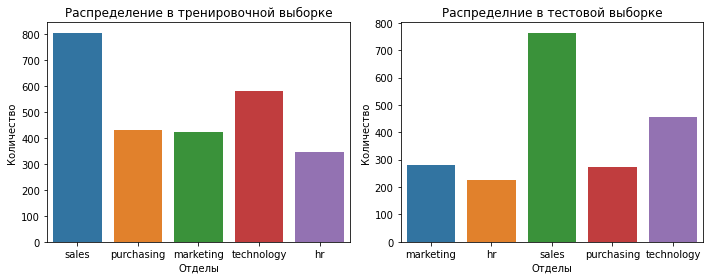

In [72]:
# Создание гистограмм по столбцу "dept"
x1 = train2['dept']
x2 = merged_test2['dept']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Отделы')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Отделы')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

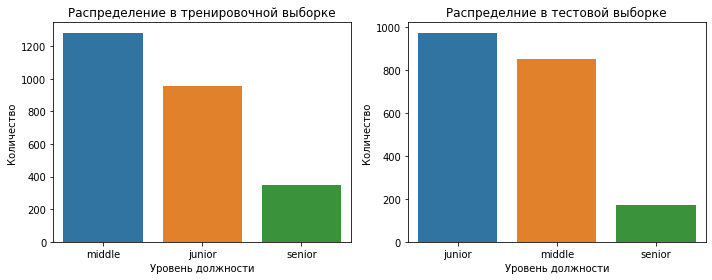

In [73]:
# Создание гистограмм по столбцу "level"
x1 = train2['level']
x2 = merged_test2['level']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Уровень должности')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Уровень должности')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

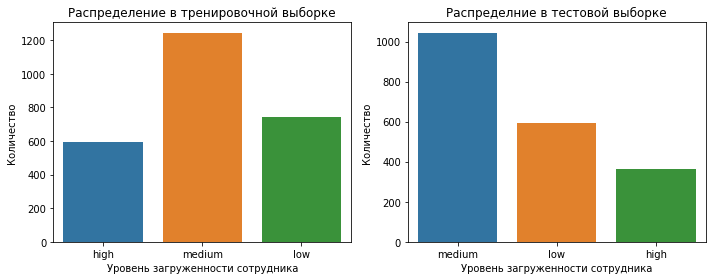

In [74]:
# Создание гистограмм по столбцу "workload"
x1 = train2['workload']
x2 = merged_test2['workload']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Уровень загруженности сотрудника')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Уровень загруженности сотрудника')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

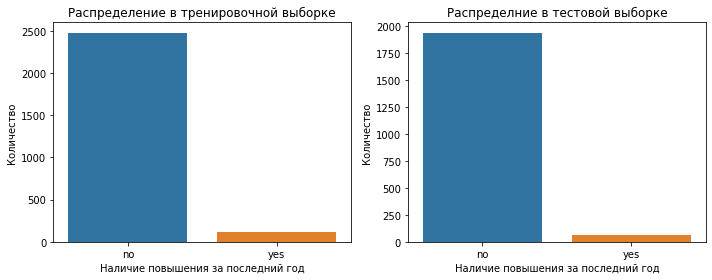

In [75]:
# Создание гистограмм по столбцу "last_year_promo"
x1 = train2['last_year_promo']
x2 = merged_test2['last_year_promo']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Наличие повышения за последний год')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Наличие повышения за последний год')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

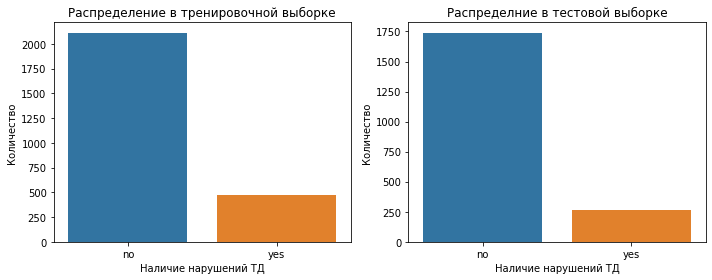

In [76]:
# Создание гистограмм по столбцу "last_year_violations"
x1 = train2['last_year_violations']
x2 = merged_test2['last_year_violations']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Наличие нарушений ТД')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Наличие нарушений ТД')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

**Посмотрим на количественные признаки**

In [77]:
train2.describe()

,employment_years,supervisor_evaluation,salary
count,2587.000000,2587.000000,2587.000000
mean,4.213375,3.367994,37107.692308
std,2.601105,1.080243,16267.354906
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,24000.000000
50%,4.000000,3.000000,33600.000000
75%,6.000000,4.000000,46800.000000
max,10.000000,5.000000,96000.000000


In [78]:
merged_test2.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


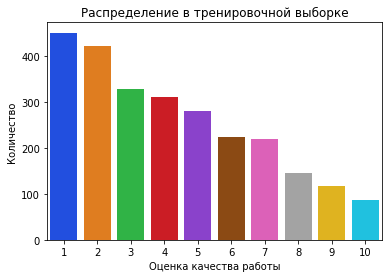

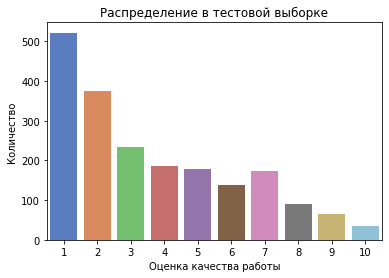

In [79]:
sns.countplot(x='employment_years', data=train2, palette='bright')
plt.title('Распределение в тренировочной выборке')
plt.xlabel('Оценка качества работы')
plt.ylabel('Количество')
plt.show()

sns.countplot(x='employment_years', data=merged_test2, palette='muted')
plt.title('Распределение в тестовой выборке')
plt.xlabel('Оценка качества работы')
plt.ylabel('Количество')
plt.show()

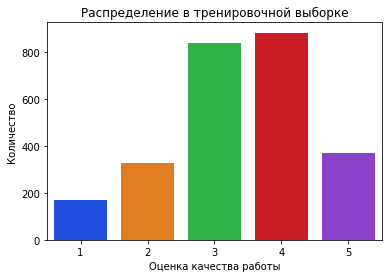

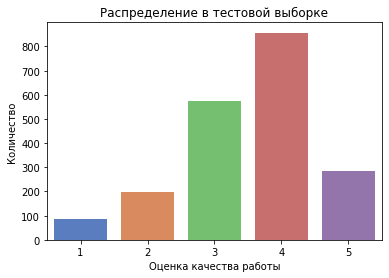

In [80]:
sns.countplot(x='supervisor_evaluation', data=train2, palette='bright')
plt.title('Распределение в тренировочной выборке')
plt.xlabel('Оценка качества работы')
plt.ylabel('Количество')
plt.show()

sns.countplot(x='supervisor_evaluation', data=merged_test2, palette='muted')
plt.title('Распределение в тестовой выборке')
plt.xlabel('Оценка качества работы')
plt.ylabel('Количество')
plt.show()

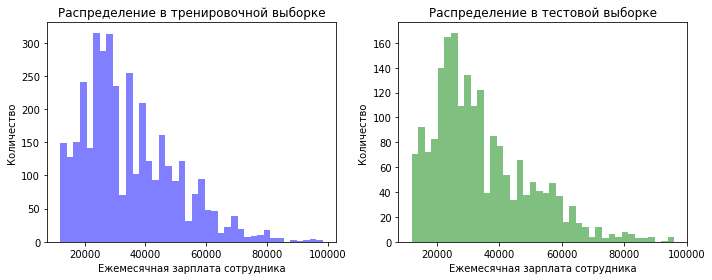

In [81]:
# Создание данных для гистограмм 'salary'
x1 = train['salary']
x2 = X_test['salary']

# Создание гистограмм
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(x1, bins=40, color='blue', alpha=0.5)
ax[0].set_title('Распределение в тренировочной выборке')
ax[0].set_xlabel('Ежемесячная зарплата сотрудника')
ax[0].set_ylabel('Количество')
ax[1].hist(x2, bins=40, color='green', alpha=0.5)
ax[1].set_title('Распределение в тестовой выборке')
ax[1].set_xlabel('Ежемесячная зарплата сотрудника')
ax[1].set_ylabel('Количество')

#Настройка внешнего вида графика
plt.tight_layout()
plt.show()

**Посмотрим на целевой признаки**

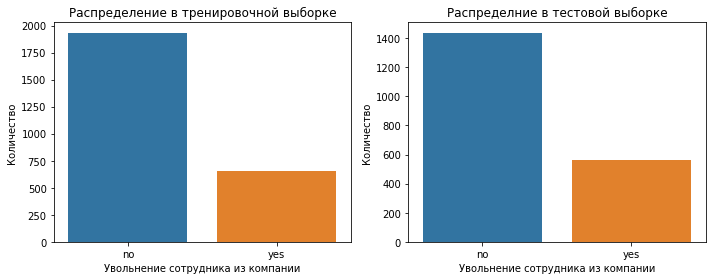

In [82]:
# Создание гистограмм по столбцу "quit"
x1 = train2['quit']
x2 = merged_test2['quit']

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.countplot(x=x1, ax=ax[0])
ax[0].set_xlabel('Увольнение сотрудника из компании')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение в тренировочной выборке')
sns.countplot(x=x2, ax=ax[1])
ax[1].set_xlabel('Увольнение сотрудника из компании')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределние в тестовой выборке')

# Настройка внешнего вида графика
plt.tight_layout()
plt.show()

**Выводы по исследовательскому анализу**

Рассмотрев категориальные и количественные признаки в двух выборках можно сказать следующее:
- Данные в тренировочной и тестовой выборках распределены пропорционально, так что особо они не отличаются 
- выбросов и аномалий не наблюдается

**Посмотрим на корреляцию**

In [83]:
train2.phik_matrix(interval_cols = ['salary']).style.background_gradient(cmap ='coolwarm')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.000000,0.000000,0.044039,0.000000,0.000000,0.055998,0.034613,0.239042,0.000000
level,0.000000,1.000000,0.414128,0.638252,0.103413,0.042457,0.061166,0.727991,0.338524
workload,0.044039,0.414128,1.000000,0.135005,0.035267,0.000000,0.032617,0.773574,0.120695
employment_years,0.000000,0.638252,0.135005,1.000000,0.147766,0.046407,0.000000,0.428708,0.666228
last_year_promo,0.000000,0.103413,0.035267,0.147766,1.000000,0.052905,0.071082,0.187656,0.179750
last_year_violations,0.055998,0.042457,0.000000,0.046407,0.052905,1.000000,0.167330,0.120240,0.208791
supervisor_evaluation,0.034613,0.061166,0.032617,0.000000,0.071082,0.167330,1.000000,0.121599,0.187561
salary,0.239042,0.727991,0.773574,0.428708,0.187656,0.120240,0.121599,1.000000,0.557247
quit,0.000000,0.338524,0.120695,0.666228,0.179750,0.208791,0.187561,0.557247,1.000000


In [84]:
merged_test2.phik_matrix(interval_cols = ['salary']).style.background_gradient(cmap ='coolwarm')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.000000,0.000000,0.033894,0.000000,0.000000,0.000000,0.060917,0.330406,0.000000
level,0.000000,1.000000,0.474151,0.689666,0.118258,0.017527,0.000000,0.748998,0.293623
workload,0.033894,0.474151,1.000000,0.202240,0.035609,0.000000,0.036353,0.785849,0.102151
employment_years,0.000000,0.689666,0.202240,1.000000,0.173637,0.066371,0.000000,0.494701,0.605927
last_year_promo,0.000000,0.118258,0.035609,0.173637,1.000000,0.000000,0.011704,0.193727,0.137762
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.174740
supervisor_evaluation,0.060917,0.000000,0.036353,0.000000,0.011704,0.189719,1.000000,0.114588,0.294738
salary,0.330406,0.748998,0.785849,0.494701,0.193727,0.000000,0.114588,1.000000,0.508308
quit,0.000000,0.293623,0.102151,0.605927,0.137762,0.174740,0.294738,0.508308,1.000000


**Выводы относительно корреляции:**
- Корреляция признаков в тестовой и тренировочной выборках примерно одинаковая
- Т.к. связь между признаками менее 0.9 править/удалять ничего не надо
- Сильная связь в тренировочной выборке между целевым признаком quit и признаками salary & employment_year
- Стоит отметить сильную связь в обеих выборках между признаками salary, level, employment_year и workloaad

**Портрет уволившегося сотрудника**

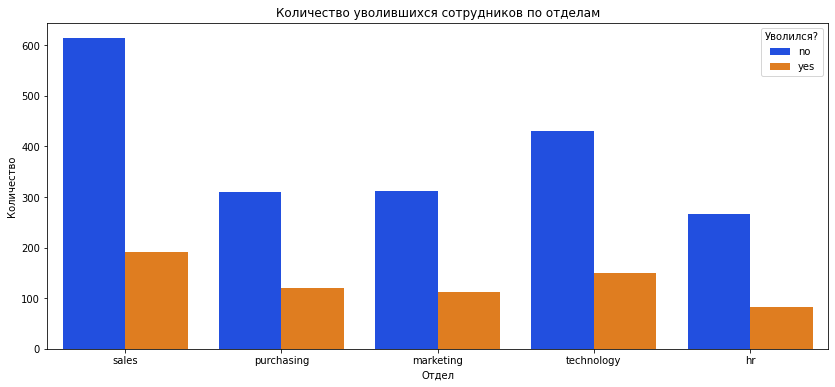

In [85]:
plt.figure(figsize=(14, 6))
sns.countplot(x='dept', hue='quit', data=train2, palette='bright')
plt.title('Количество уволившихся сотрудников по отделам')
plt.xlabel('Отдел')
plt.ylabel('Количество')
plt.legend(title='Уволился?', loc='upper right')
plt.show()

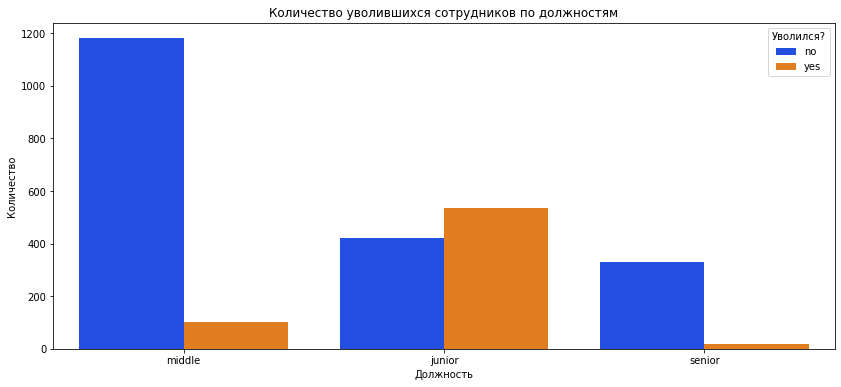

In [86]:
plt.figure(figsize=(14, 6))
sns.countplot(x='level', hue='quit', data=train2, palette='bright')
plt.title('Количество уволившихся сотрудников по должностям')
plt.xlabel('Должность')
plt.ylabel('Количество')
plt.legend(title='Уволился?', loc='upper right')
plt.show()

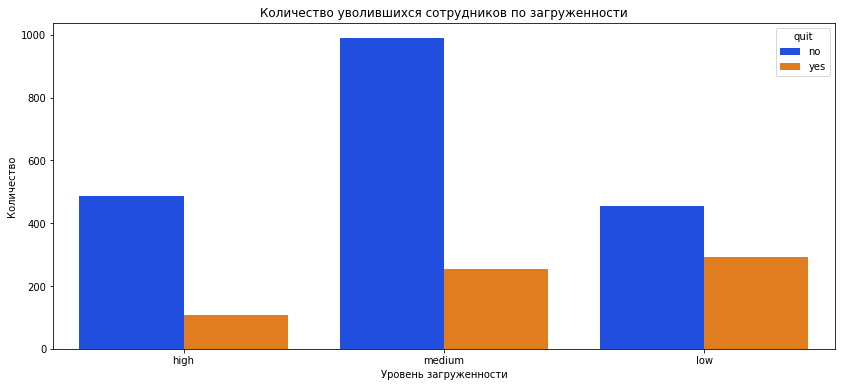

In [87]:
plt.figure(figsize=(14, 6))
sns.countplot(x='workload', hue='quit', data=train2, palette='bright')
plt.title('Количество уволившихся сотрудников по загруженности')
plt.xlabel('Уровень загруженности')
plt.ylabel('Количество')
plt.show()

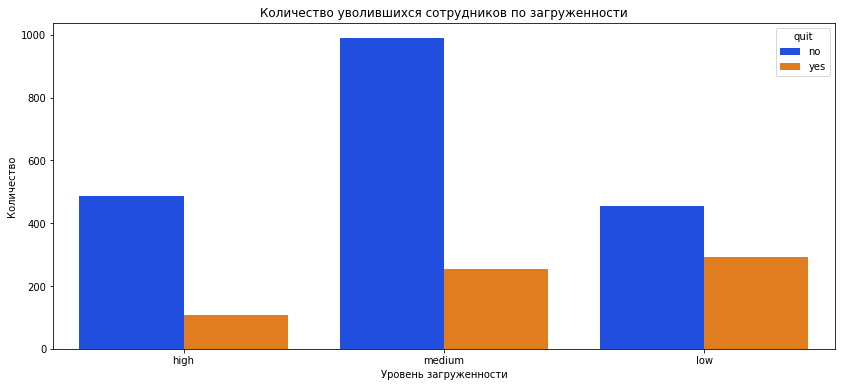

In [88]:
plt.figure(figsize=(14, 6))
sns.countplot(x='workload', hue='quit', data=train2, palette='bright')
plt.title('Количество уволившихся сотрудников по загруженности')
plt.xlabel('Уровень загруженности')
plt.ylabel('Количество')
plt.show()

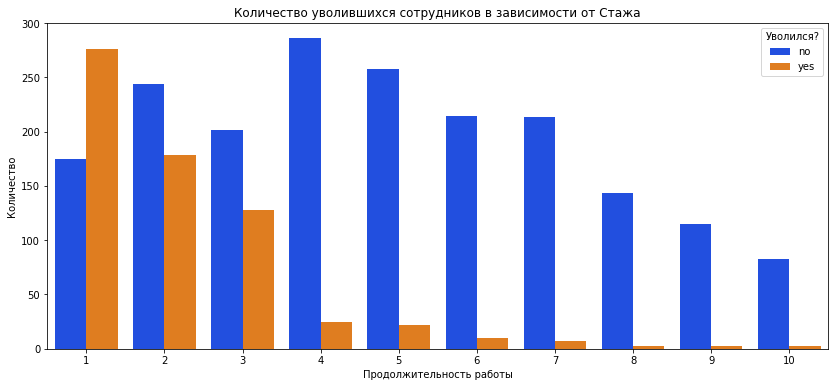

In [89]:
plt.figure(figsize=(14, 6))
sns.countplot(x='employment_years', hue='quit', data=train2, palette='bright')
plt.title('Количество уволившихся сотрудников в зависимости от Стажа')
plt.xlabel('Продолжительность работы')
plt.ylabel('Количество')
plt.legend(title='Уволился?', loc='upper right')
plt.show()

In [90]:
display(train2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...
778735,technology,junior,low,2,no,no,4,22800,yes
106936,marketing,junior,low,1,no,no,5,18000,no
775320,technology,junior,high,1,no,no,4,42000,yes


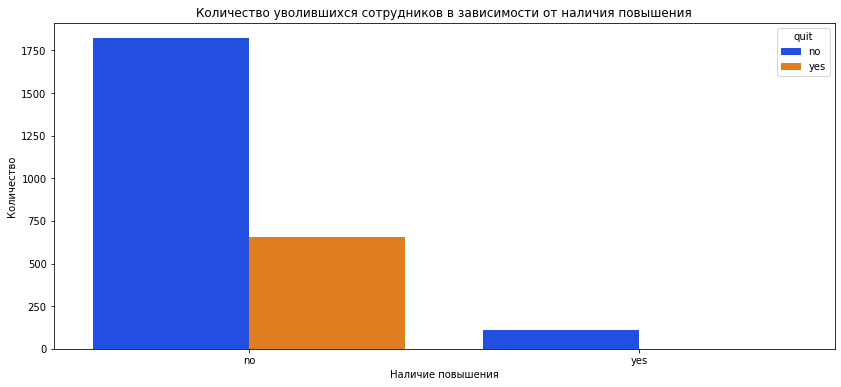

In [91]:
plt.figure(figsize=(14, 6))
sns.countplot(x='last_year_promo', hue='quit', data=train2, palette='bright')
plt.title('Количество уволившихся сотрудников в зависимости от наличия повышения')
plt.xlabel('Наличие повышения')
plt.ylabel('Количество')
plt.show()

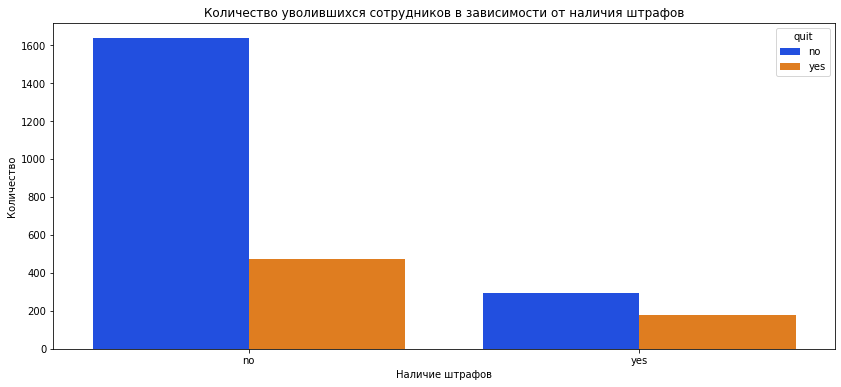

In [92]:
plt.figure(figsize=(14, 6))
sns.countplot(x='last_year_violations', hue='quit', data=train2, palette='bright')
plt.title('Количество уволившихся сотрудников в зависимости от наличия штрафов')
plt.xlabel('Наличие штрафов')
plt.ylabel('Количество')
plt.show()

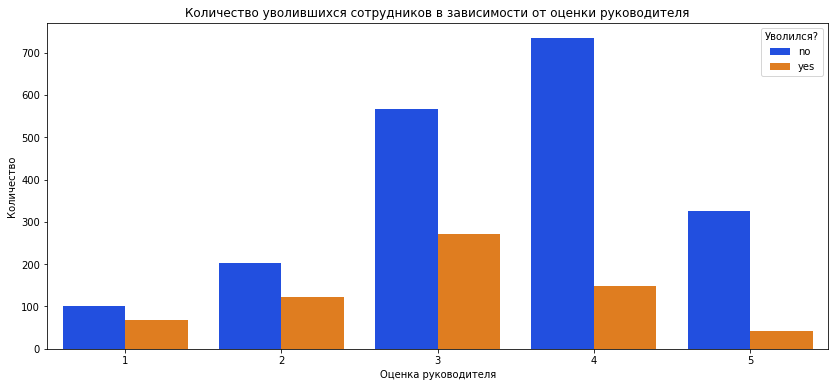

In [93]:
plt.figure(figsize=(14, 6))
sns.countplot(x='supervisor_evaluation', hue='quit', data=train2, palette='bright')
plt.title('Количество уволившихся сотрудников в зависимости от оценки руководителя')
plt.xlabel('Оценка руководителя')
plt.ylabel('Количество')
plt.legend(title='Уволился?', loc='upper right')
plt.show()

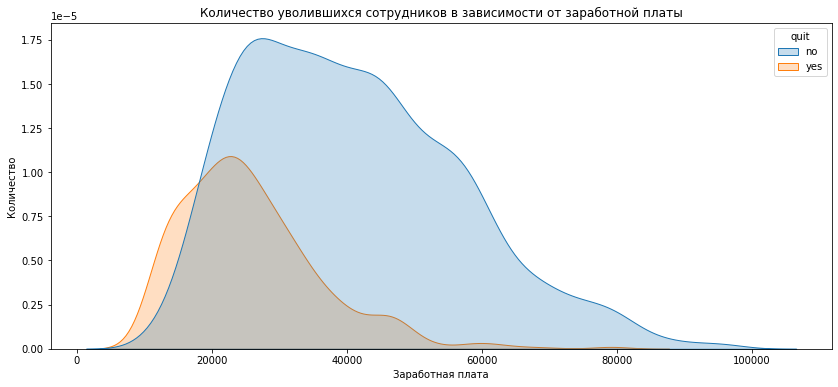

In [94]:
plt.figure(figsize=(14, 6))
sns.kdeplot(data=train2, x='salary', hue='quit', fill=True)
plt.title('Количество уволившихся сотрудников в зависимости от заработной платы')
plt.xlabel('Заработная плата')
plt.ylabel('Количество')
plt.show()

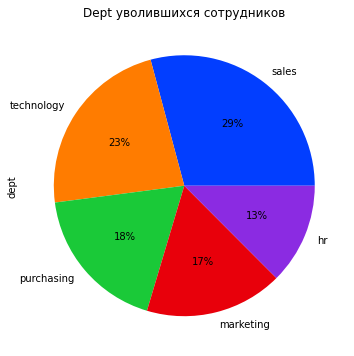

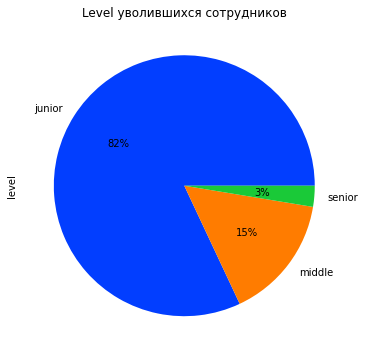

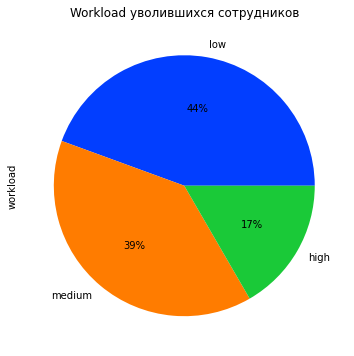

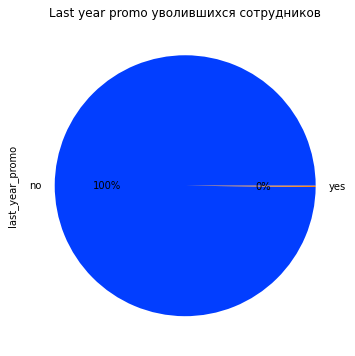

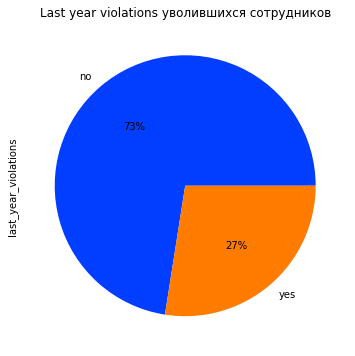

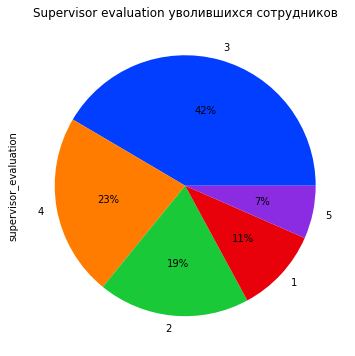

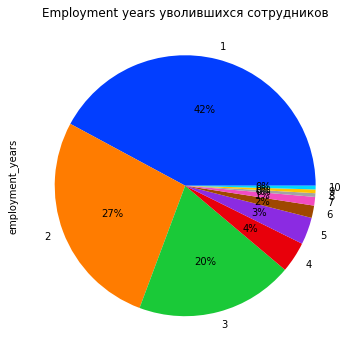

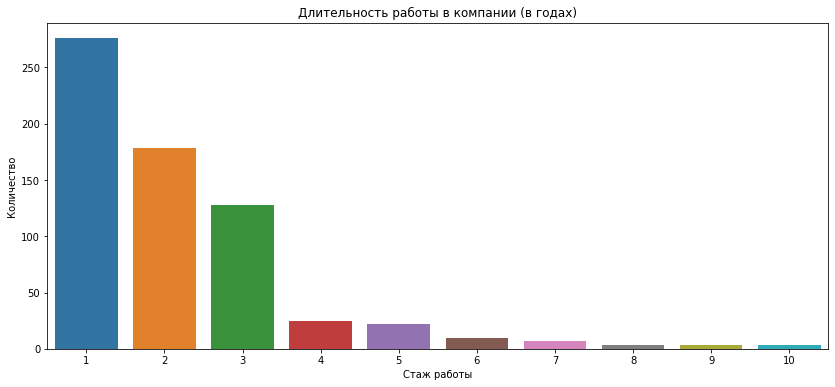

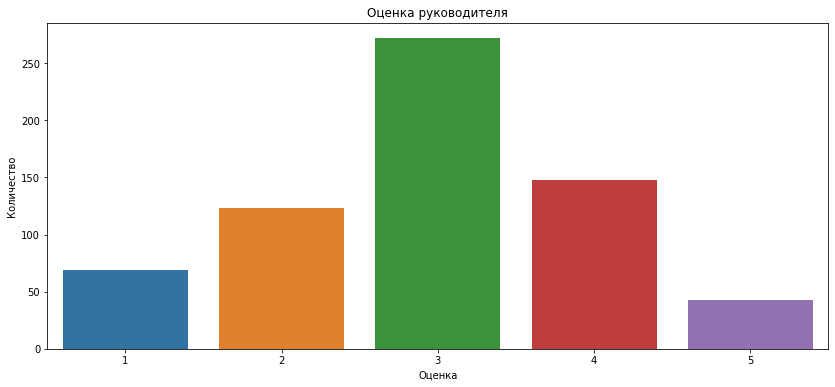

In [95]:
def plot_counts(df, col, title, color_palette="bright"):
    palette_color = sns.color_palette(color_palette)
    df[col].value_counts().plot(kind='pie', autopct='%1.0f%%', title=title, colors=palette_color, figsize=(14, 6))
    plt.show()

# Применение функции для всех столбцов
columns = ["dept", "level", "workload", "last_year_promo", "last_year_violations", "supervisor_evaluation", "employment_years"]
for c in columns:
    plot_counts(train2.loc[train2['quit'] == 'yes'], c, f"{c.replace('_', ' ').capitalize()} уволившихся сотрудников", color_palette="bright")

    
plt.figure(figsize=(14, 6))
sns.countplot(data=train2[train2['quit'] == 'yes'], x='employment_years')
plt.title('Длительность работы в компании (в годах)')
plt.xlabel('Стаж работы')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(data=train2[train2['quit'] == 'yes'], x='supervisor_evaluation')
plt.title('Оценка руководителя')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

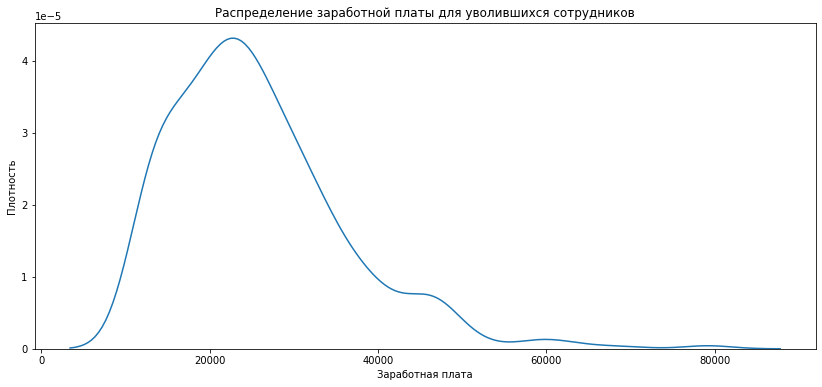

In [96]:
plt.figure(figsize=(14, 6))
sns.kdeplot(data=train2[train2['quit'] == 'yes'], x='salary')
plt.title('Распределение заработной платы для уволившихся сотрудников')
plt.xlabel('Заработная плата')
plt.ylabel('Плотность')
plt.show()

**Портрет уволившегося сотрудника выглядит так**
- в большинстве случаяв это джуны, которые отработали менее 3 лет в компании 
- и руководитель удовлетворен работой сотрудника на 3 и менее баллов
- в большиснтве случаев это сотрудники из отдела продаж, либо технического 
- немаловажно является то, что не получая повышения, сотрудники уходят, скорее всего джуны отработав 2 года, не получают повышения и идут пытать счастье в другой компании 
- размер зарплаты также влияет на уход сотрудника, если он удовлетворен работой менее чем на 50%, он имеет зарплату менее 30000 рублей, велика вероятность, что сотрудник покинет компанию 

**Проверка гипотезы, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник**

In [97]:
#Объединим таблицы 
merged_test2=merged_test2.merge(y_test, on='id', how='outer')
display(merged_test2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
686555,hr,junior,medium,1,no,no,4,30000,no,0.72
467458,sales,middle,low,5,no,no,4,19200,no,0.64
418655,sales,middle,low,6,no,no,4,19200,no,0.60
789145,hr,middle,medium,5,no,no,5,40800,no,0.75
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,yes,0.56
109582,technology,middle,low,3,no,no,2,21600,yes,0.14
305653,technology,junior,low,1,no,no,3,14400,yes,0.11


Text(0, 0.5, 'Уровень удовлетворенности')

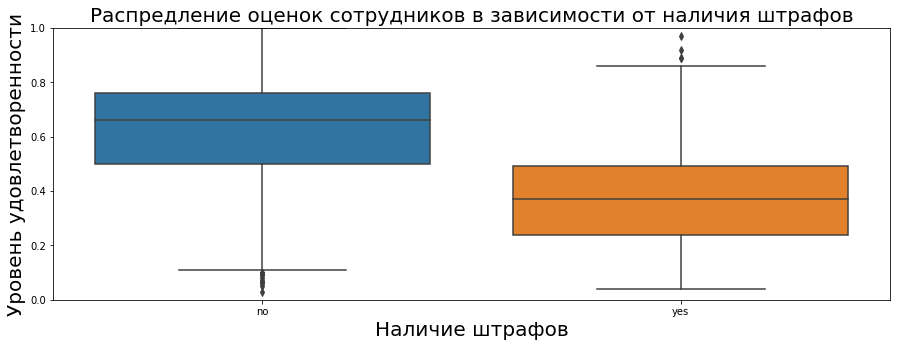

In [98]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=merged_test2, x='quit', y='job_satisfaction_rate')
ax.set(ylim=(0,1))
plt.title('Распредление оценок сотрудников в зависимости от наличия штрафов', fontsize=20)
plt.xlabel('Наличие штрафов', fontsize=20)
plt.ylabel('Уровень удовлетворенности',fontsize=20)

Все выглядит довольно логично, чем меньше удовлетворен сотрудник работой, тем выше вероятность, что он покинет компанию. Гипотеза вверна.

# Шаг 4. Задача 2. Добавление нового входного признака

Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [99]:
merged_test2 = merged_test2.drop('job_satisfaction_rate', axis=1)
display(merged_test2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,yes
109582,technology,middle,low,3,no,no,2,21600,yes
305653,technology,junior,low,1,no,no,3,14400,yes


In [100]:
train2['job_satisfaction_rate'] = grid_search.predict(train2)
merged_test2['job_satisfaction_rate'] = grid_search.predict(merged_test2)

display(train2)
display(merged_test2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.600000
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000
...,...,...,...,...,...,...,...,...,...,...
778735,technology,junior,low,2,no,no,4,22800,yes,0.845000
106936,marketing,junior,low,1,no,no,5,18000,no,0.880000
775320,technology,junior,high,1,no,no,4,42000,yes,0.571429


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.885000
686555,hr,junior,medium,1,no,no,4,30000,no,0.681429
467458,sales,middle,low,5,no,no,4,19200,no,0.654000
418655,sales,middle,low,6,no,no,4,19200,no,0.655000
789145,hr,middle,medium,5,no,no,5,40800,no,0.812500
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,yes,0.508571
109582,technology,middle,low,3,no,no,2,21600,yes,0.151429
305653,technology,junior,low,1,no,no,3,14400,yes,0.170000


**Вывод по Шагу 4. Задача 2**

Новый входной признак добавлен

# Шаг 5. Задача 2. Подготовка данных

In [101]:
X_train = train2.drop(['quit'], axis = 1)
y_train = train2['quit']

X_train.shape, y_train.shape

((2587, 9), (2587,))

In [102]:
X_test = merged_test2.drop(['quit'], axis = 1)
y_test = merged_test2['quit']

X_test.shape, y_test.shape

((2000, 9), (2000,))

In [103]:
quit_le = LabelEncoder()
quit_le.fit(y_train)
y_train = quit_le.transform(y_train)

Создаём списки с названиями признаков

In [104]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary', 'job_satisfaction_rate']

Создаём итоговый пайплайн: подготовка данных и модель

In [105]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

Перебираем гиперпараметры моделей

In [106]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 12),
        'models__max_features': range(2, 12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='rbf', probability=True)],
        'models__degree': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Автоматический подбор с помощью RandomizedSearchCV

In [107]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(2, 9),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 9),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

Вывод лучшей модели и метрик

In [108]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Работа модели на тестовой выборке

In [109]:
y_predict_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_predict_proba[:, 1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.91


**Выводы по Задаче 2**
- Обучили наилучшую модель для прогнозирования увольнения сотрудников
- Метрика на тестовой выборке достигла значения 0.91
- Наиболее эффективной моделью оказалась DecisionTreeClassifier(max_depth=5, max_features=11, random_state=42)

# Шаг 7. Общий Вывод по Задачам 1 и 2 

**В ходе решения кейса были решены 2 задачи** 
- Во-первых, построена модель, способная предсказать уровень удовлетворенности сотрудника на основе предоставленных данных. Это важно для бизнеса, так как удовлетворение работой напрямую связано с текучестью кадров. Предсказание текучести кадров — ключевая задача для аналитиков HR. Внезапные увольнения могут привести к значительным рискам для компании, особенно когда уходят важные сотрудники.
- Во-вторых, создана модель, которая предсказывает вероятность увольнения сотрудника исходя из предоставленных данных.

**В ходе исследования были выполнены следующие шаги:**
- Загружены и проверены первоначальное данные.
- Проверили данные на наличие пропусков и дубликатов.
- Проанализировали данные, построив графики и матрицы корреляции.
- Подготовили данные путем написания пайплайна для обработки, включая кодирование и нормализацию.
- Обучили модели для тестирования различных моделей с помощью методов масштабирования и гиперпараметров
- Найдены лучшие модели для предсказания уровня удовлетворенности и возможности увольнения сотрудников из компании 

**Составлен портрет сотрудника, который скорее всего покинет компанию**
- В большинстве случаяв это джуны, которые отработали менее 2 лет в компании 
- Если руководитель удовлетворен работой сотрудника менее чем на 3 балла, то и сотрудник удовлетворен работой менее чем на 50%
- В большиснтве случаев это сотрудники из отдела продаж, либо технического 
- Немаловажно является то, что не получая повышения, сотрудники уходят, скорее всего джуны отработав 2 года, не получают повышения и идут пытать счастье в другой компании 
- Размер зарплаты также влияет на уход сотрудника, если он удовлетворен работой менее чем на 50%, он имеет зарплату менее 40000 рублей, велика вероятность, что сотрудник покинет компанию 

**Рекомендации для бизнеса**
- Большинство увольнений произошло среди сотрудников отделов продаж и технологий, поэтому целесообразно обратить внимание на эти отделы.
- Следует уделять больше внимания сотрудникам, которые находятся на позиции junior и отработали менее 2 лет, возможно необходимо разработать поощрения для этой группы
- Существует связь между увольнением и удовлетворённостью сотрудника. Используя разработанные модели, можно предсказывать уровень удовлетворения сотрудников и принимать соответствующие меры для его повышения.